# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [28]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [74]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# taking 150K points for KNN in Descending Time Order
# Ascending Time order causes problem as the oldest data is 20 years old (dated 1999) and we do not want such old
# data. Instead we will swap the train and test split in the code down the line so that Test has the most recent
# data.

# 150000 data points were used for brute force KNN
#filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 ORDER BY Time DESC LIMIT 150000""", con) 

# reducing the dataset size for kd-tree to 10000 to reduce the time taken
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 ORDER BY Time DESC LIMIT 50000""", con)

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(5)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,1,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...
1,1089,B004FD13RW,A1BPLP0BKERV,Paul,0,0,1,1351209600,It is awesome.,"My partner is very happy with the tea, and is ..."
2,5703,B009WSNWC4,AMP7K1O84DH1T,ESTY,0,0,1,1351209600,DELICIOUS,Purchased this product at a local store in NY ...
3,5924,B00523NRVO,A2JDXKFZ0PFHKU,James W. Shondel,0,0,1,1351209600,The perfect pop!,"These lollipops are are well done, look exactl..."
4,7178,B004OQLIHK,AKHQMSUORSA91,Pen Name,0,0,1,1351209600,Delicious!,I have ordered these raisins multiple times. ...


In [75]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [76]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [77]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [78]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [79]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [80]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [81]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(35610, 10)

In [82]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

71.22

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [83]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [84]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [85]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(35610, 10)


1    29450
0     6160
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [86]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

TITLE: Chicken Soup with Rice<br />AUTHOR: Maurice Sendak<br />REVIEWER: Josh Grossman, Colonel {r}, U.S.A.R., M.C., M.D., FACP<br />Rural physician/author/educator-Mentor U.S.M.L.E. Step 3...<br />>Who would believe that I have memorized this book?<br />>Who would believe that I can recite any month in any order?<br />>Who would believe that I read my copy to tatters while reading to my children now professional adults?<br />>Who would believe that my grandchildren read their copy to tatters?<br />I can be confident that generations of children will enjoy "Chicken Soup with Rice"<br />Bravo!<br />Thank you!<br />Respectfully submitted...
Good product.  Easily fits inside golf bag.  Will keep your beer cold the entire round.  With most course not allowing you to bring outside beverages onto the course this is a stealth way of doing so.
The product is what it advertise to be. If you expect it to taste as fresh eggs you will be disappointed. Nevertheless, you can make great omelettes and

In [87]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

TITLE: Chicken Soup with Rice<br />AUTHOR: Maurice Sendak<br />REVIEWER: Josh Grossman, Colonel {r}, U.S.A.R., M.C., M.D., FACP<br />Rural physician/author/educator-Mentor U.S.M.L.E. Step 3...<br />>Who would believe that I have memorized this book?<br />>Who would believe that I can recite any month in any order?<br />>Who would believe that I read my copy to tatters while reading to my children now professional adults?<br />>Who would believe that my grandchildren read their copy to tatters?<br />I can be confident that generations of children will enjoy "Chicken Soup with Rice"<br />Bravo!<br />Thank you!<br />Respectfully submitted...


In [88]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

TITLE: Chicken Soup with RiceAUTHOR: Maurice SendakREVIEWER: Josh Grossman, Colonel {r}, U.S.A.R., M.C., M.D., FACPRural physician/author/educator-Mentor U.S.M.L.E. Step 3...>Who would believe that I have memorized this book?>Who would believe that I can recite any month in any order?>Who would believe that I read my copy to tatters while reading to my children now professional adults?>Who would believe that my grandchildren read their copy to tatters?I can be confident that generations of children will enjoy "Chicken Soup with Rice"Bravo!Thank you!Respectfully submitted...
Good product.  Easily fits inside golf bag.  Will keep your beer cold the entire round.  With most course not allowing you to bring outside beverages onto the course this is a stealth way of doing so.
The product is what it advertise to be. If you expect it to taste as fresh eggs you will be disappointed. Nevertheless, you can make great omelettes and scramble eggs concoctions. Easy to mix and cook. After mixing wit

In [89]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [90]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

The product is what it advertise to be. If you expect it to taste as fresh eggs you will be disappointed. Nevertheless, you can make great omelettes and scramble eggs concoctions. Easy to mix and cook. After mixing with water it looks thinner than regular eggs, but it cooks well. If you are not sure, order powdered eggs in a smaller package and try it first. Will definitely buy again once it runs out.


In [91]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

TITLE: Chicken Soup with Rice<br />AUTHOR: Maurice Sendak<br />REVIEWER: Josh Grossman, Colonel {r}, U.S.A.R., M.C., M.D., FACP<br />Rural physician/author/educator-Mentor U.S.M.L.E. Step  />>Who would believe that I have memorized this book?<br />>Who would believe that I can recite any month in any order?<br />>Who would believe that I read my copy to tatters while reading to my children now professional adults?<br />>Who would believe that my grandchildren read their copy to tatters?<br />I can be confident that generations of children will enjoy "Chicken Soup with Rice"<br />Bravo!<br />Thank you!<br />Respectfully submitted...


In [92]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

The product is what it advertise to be If you expect it to taste as fresh eggs you will be disappointed Nevertheless you can make great omelettes and scramble eggs concoctions Easy to mix and cook After mixing with water it looks thinner than regular eggs but it cooks well If you are not sure order powdered eggs in a smaller package and try it first Will definitely buy again once it runs out 


In [93]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [94]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 35610/35610 [00:13<00:00, 2597.24it/s]


In [95]:
print(preprocessed_reviews[100])
print(len(preprocessed_reviews))

used brand years feeling clogged ate massive meal sips tea new make sure home work little well know mean careful first couple times using try little sips see result morning earlier follow lots water
35610


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [96]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [42]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [36]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [38]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [39]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [41]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

In [97]:
Y = final['Score']
X = preprocessed_reviews
#make sure we have correct X and Y 
print(Y.shape)
print(len(X))

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import math

import seaborn as sns
import matplotlib.pyplot as plt  


#  Train on oldest data (eg. Now - 90 days), CV on somewhat recent  data (eg. Now - 30 days) and Test on recent data (T-15)
# doing a time series split:  swapped the test and train as our data is in DESCENDING time order
# and we want X_test to have the most recent data.
X_test, X_train, y_test, y_train = train_test_split(X, Y, test_size=0.77, shuffle=False)

# time series splitting
X_cv, X_train, y_cv, y_train = train_test_split(X_train, y_train, test_size=0.77, shuffle=False) 
# do random between train and CV
#X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33)

print('X_train size=' , len(X_train))
print('X_cv size=', len(X_cv))
print('X_test size=', len(X_test))
print('y_train class counts')
print(y_train.value_counts())
print('y_cv class counts')
print(y_cv.value_counts())
print('y_test class counts')
print(y_test.value_counts())

#the following should all be the same.
#print(X_test[0])
#print(preprocessed_reviews[0])
#print(final['Text'].values[0])

K = [1, 5, 10, 15, 21, 31, 41, 51]

def computeWithBestK(best_k, xtrain, ytrain, xtest, ytest, algo):
    neigh = KNeighborsClassifier(n_neighbors=best_k, algorithm=algo)
    neigh.fit(xtrain, ytrain)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    train_fpr, train_tpr, thresholds = roc_curve(ytrain, neigh.predict_proba(xtrain)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(ytest, neigh.predict_proba(xtest)[:,1])
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()
    print("="*100)
    
    print('y_train class counts')
    print(ytrain.value_counts())
    print('y_test class counts')
    print(ytest.value_counts())
    print("Train confusion matrix")
    print(confusion_matrix(ytrain, neigh.predict(xtrain)))
    print("Test confusion matrix")
    print(confusion_matrix(ytest, neigh.predict(xtest)))

def findBestK(X_train, y_train, X_cv, y_cv, kvalues, algo):
    """ y_true : array, shape = [n_samples] or [n_samples, n_classes]
    True binary labels or binary label indicators.
    y_score : array, shape = [n_samples] or [n_samples, n_classes]
    Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
    decisions (as returned by “decision_function” on some classifiers). 
    For binary y_true, y_score is supposed to be the score of the class with greater label.
    """
    train_auc = []
    cv_auc = []
    bestk = kvalues[0]
    aucDiff = math.inf
    for i in tqdm(kvalues):
        neigh = KNeighborsClassifier(n_neighbors=i, algorithm=algo)
        neigh.fit(X_train, y_train)
        # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
        # not the predicted outputs
        y_train_pred =  neigh.predict_proba(X_train)[:,1]
        y_cv_pred =  neigh.predict_proba(X_cv)[:,1]
        train_auc = roc_auc_score(y_train,y_train_pred)
        cv_auc = roc_auc_score(y_cv, y_cv_pred)
        difference = train_auc - cv_auc
        if difference < aucDiff:
            aucDiff = difference
            bestk = i
            
        train_auc.append()
        cv_auc.append()

    plt.plot(kvalues, train_auc, label='Train AUC')
    plt.scatter(kvalues, train_auc, label='Train AUC')
    plt.plot(kvalues, cv_auc, label='CV AUC')
    plt.scatter(kvalues, cv_auc, label='CV AUC')
    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()
    return bestk


    

(35610,)
35610
X_train size= 21114
X_cv size= 6306
X_test size= 8190
y_train class counts
1    17598
0     3516
Name: Score, dtype: int64
y_cv class counts
1    5159
0    1147
Name: Score, dtype: int64
y_test class counts
1    6693
0    1497
Name: Score, dtype: int64


### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

  0%|          | 0/8 [00:00<?, ?it/s]

After vectorizations
(62558, 46863) (62558,)
(18686, 46863) (18686,)
(24267, 46863) (24267,)
<class 'scipy.sparse.csr.csr_matrix'>


100%|██████████| 8/8 [34:58<00:00, 262.96s/it]


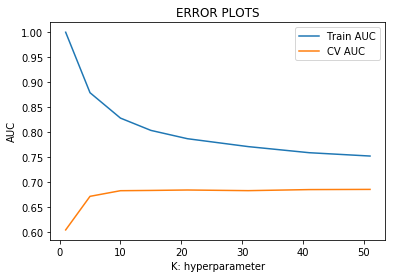

In [33]:


from sklearn.feature_extraction.text import CountVectorizer

# missed providing min_df
vectorizer = CountVectorizer()

# While vectorizing your data, apply the method fit_transform() on you train data, 
# and apply the method transform() on cv/test data.
# THE VOCABULARY SHOULD BUILT ONLY WITH THE WORDS OF TRAIN DATA
vectorizer.fit(X_train) 

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print(type(X_train_bow))

# this was run with 50k data points
bestk = findBestK(X_train_bow, y_train, X_cv_bow, y_cv, K, 'brute')



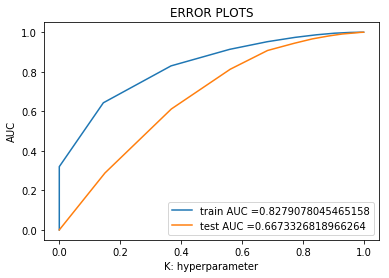

Train confusion matrix
[[ 3330  7171]
 [ 2499 49558]]
Test confusion matrix
[[ 1026  3466]
 [ 1107 18668]]


In [34]:

computeWithBestK(bestk, X_train_bow, y_train, X_test_bow, y_test, 'brute')   


### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

  0%|          | 0/8 [00:00<?, ?it/s]

After vectorizations
(62558, 38031) (62558,)
(18686, 38031) (18686,)
(24267, 38031) (24267,)
<class 'scipy.sparse.csr.csr_matrix'>


100%|██████████| 8/8 [39:00<00:00, 296.53s/it]


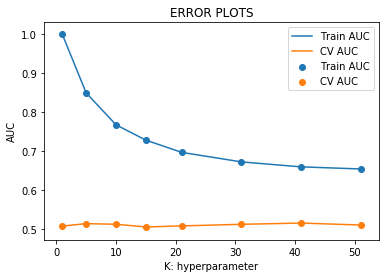

In [60]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=10)
vectorizer.fit(X_train) 

# we use the fitted vectorizer to convert the text to vector
X_train_tfidf = vectorizer.transform(X_train)
X_cv_tfidf = vectorizer.transform(X_cv)
X_test_tfidf = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)

print(type(X_train_tfidf))

# this was run with 150k data points
findBestK(X_train_tfidf, y_train, X_cv_tfidf, y_cv, K, 'brute')


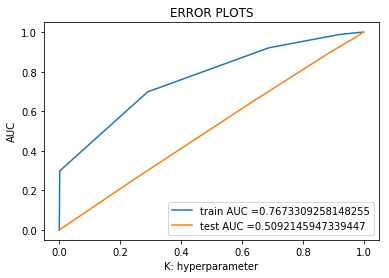

Train confusion matrix
[[  163 10338]
 [   53 52004]]
Test confusion matrix
[[   22  4470]
 [   55 19720]]


In [61]:
#for TFIDF the best score seems to be around K=40 however overall the AUC seems to indicate an average model.
bestk = 10   
computeWithBestK(bestk, X_train_tfidf, y_train, X_test_tfidf, y_test, 'brute')    

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [98]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors


def computeAvgW2V(X):
    list_of_sentence_train=[]
    for sentence in X:
        list_of_sentence_train.append(sentence.split())
    
    # this line of code trains your w2v model on the give list of sentances
    w2v_model=Word2Vec(list_of_sentence_train,min_count=5,size=50, workers=4)
    w2v_words = list(w2v_model.wv.vocab)

    # average Word2Vec
    # compute average word2vec for each review.
    sent_vectors_train = [] # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentence_train): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors_train.append(sent_vec)
    sent_vectors_train = np.array(sent_vectors_train)
    print(sent_vectors_train.shape)
    print(sent_vectors_train[0])
    return sent_vectors_train

100%|██████████| 62558/62558 [02:21<00:00, 443.52it/s]


(62558, 50)
[ 0.0956141  -0.09588509 -0.21131495 -0.18434832 -0.58558757 -0.10193755
 -0.42522606  0.19921311 -0.69575184 -0.5917278   0.79372043  0.1935179
 -0.38020522  0.80866488  0.68049298 -0.39613794 -0.39087397  0.16944171
 -0.46274642 -0.1873371  -0.30223544 -0.33656272  0.4065017   0.53915776
 -0.34389267  0.1857597   0.34048091  0.43953231 -0.10769706  0.26451289
 -0.91468374 -0.44146124  0.1677813   0.45220851 -0.65802206 -0.03871724
 -0.07974075  1.03034357 -0.43555852  1.04350169 -0.13713195 -0.24534033
  0.16508746 -0.28576288 -0.74990852  0.49749934  0.22049461 -0.71628084
 -0.17652292  0.2842603 ]


  0%|          | 0/8 [00:00<?, ?it/s]

(18686, 50)
[ 1.84347679e-01 -6.58501434e-01  1.36849313e-01 -2.46733146e-01
  5.73255095e-02 -8.34290719e-02  1.37296568e-01  5.43446057e-02
 -8.41252110e-01 -1.27020178e-01  3.51006283e-02  2.99762840e-01
  1.52513715e-01  4.88177994e-02  3.78493757e-01  6.71850966e-01
  1.83237182e-01 -1.18276419e-01 -2.89755117e-01 -3.98465651e-01
  2.12517617e-01 -1.39784236e-01  1.88298603e-02  1.52307932e-01
 -2.66843212e-01  1.88820348e-01 -2.90434748e-01  4.98956868e-05
  8.73898978e-01  6.26448446e-01 -1.63170435e-01  5.00768532e-02
 -4.20777488e-01 -2.71910628e-01 -5.55161254e-01  1.03775605e-01
 -3.15684538e-01  3.39466657e-01  3.10072006e-01  3.53257524e-01
  1.74011158e-01 -6.23381187e-01  2.46463701e-02 -1.86075083e-01
  3.10289115e-01  8.33608392e-03 -4.45910090e-01 -4.57401816e-01
 -5.75374357e-01  3.39470379e-01]


100%|██████████| 8/8 [16:49<00:00, 128.20s/it]


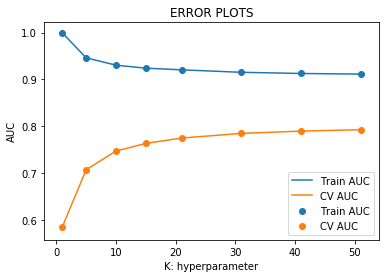

In [62]:
# this was run with 150K data points
X_train_w2vAvg = computeAvgW2V(X_train)
X_cv_w2vAvg = computeAvgW2V(X_cv)

findBestK(X_train_w2vAvg, y_train, X_cv_w2vAvg, y_cv, K, 'brute')


100%|██████████| 24267/24267 [00:42<00:00, 570.65it/s]


(24267, 50)
[ 0.05722205 -0.41714801 -0.18966312 -0.08203263  0.16622821 -0.73314584
  0.06638867  0.58827762 -0.66748154 -0.13053651  0.5681102   0.04000342
  0.35163522  0.43202972 -0.05652796 -0.21276995  0.3941835  -0.34050561
  0.00658449 -0.26944048  0.01840416  0.40283328  0.31930665 -0.26346477
  0.2911484  -0.06314379 -0.35490712 -0.1436747   0.412557    0.47062388
 -0.16643572  0.00966338  0.26763915 -0.20309302 -0.55375178  0.02616717
 -0.16545599 -0.03081029  0.6422904   0.72696385 -0.22275469 -0.39108401
 -0.42720607  0.77451868 -0.28802795 -0.17051758  0.53623273 -0.34965817
 -0.04232369  0.05083253]


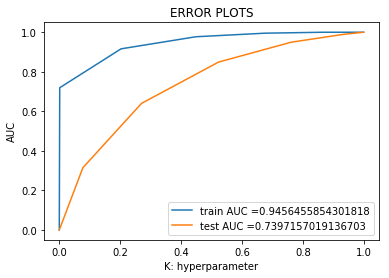

Train confusion matrix
[[ 5787  4714]
 [ 1186 50871]]
Test confusion matrix
[[ 2141  2351]
 [ 2983 16792]]


In [63]:
#bestK is at 50 on CV data
bestk = 50
# although bestk was at 50 the results below are run with bestk=5 by mistake.
# did not run it again with 50 just to save time
X_test_w2vAvg = computeAvgW2V(X_test)
computeWithBestK(bestk, X_train_w2vAvg, y_train, X_test_w2vAvg, y_test, 'brute')   

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [99]:
def computeTfIdfW2v(data):
    
    list_of_sentence_train=[]
    for sentence in data:
        list_of_sentence_train.append(sentence.split())
        
    model = TfidfVectorizer(ngram_range=(1,2), min_df=10)
    model.fit(data)
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
    
     # this line of code trains your w2v model on the give list of sentances
    w2v_model=Word2Vec(list_of_sentence_train,min_count=5,size=50, workers=4)
    w2v_words = list(w2v_model.wv.vocab)

    # TF-IDF weighted Word2Vec
    tfidf_feat = model.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sentence_train): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

100%|██████████| 8/8 [17:40<00:00, 133.55s/it]


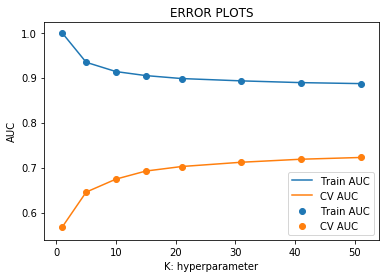

In [25]:
# this was run with 150k data points
X_train_w2vTfIdf = computeTfIdfW2v(X_train)
X_cv_w2vTfIdf = computeTfIdfW2v(X_cv)

findBestK(X_train_w2vTfIdf, y_train, X_cv_w2vTfIdf, y_cv, K, 'brute')

100%|██████████| 24267/24267 [04:24<00:00, 91.88it/s] 


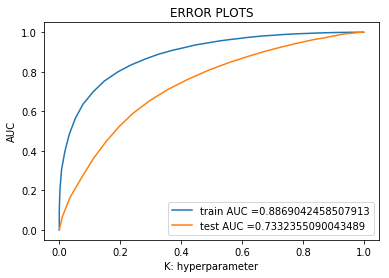

y_train class counts
1    52057
0    10501
Name: Score, dtype: int64
y_test class counts
1    19775
0     4492
Name: Score, dtype: int64
Train confusion matrix
[[ 2950  7551]
 [  690 51367]]
Test confusion matrix
[[  205  4287]
 [  116 19659]]


In [26]:
#bestK is at 50 based on CV data
bestk = 50
X_test_w2vTfIdf = computeTfIdfW2v(X_test)
computeWithBestK(bestk, X_train_w2vTfIdf, y_train, X_test_w2vTfIdf, y_test, 'brute')   

## [5.2] Applying KNN kd-tree

In [100]:
#4. You can use sparse matrices for brute force algorithm of KNN.
#5. For kd-tree algorithm you have to use dense matrices. Please note that if you pass sparse matrix as input to kd-tree algorithm then by default it will run in brute-force. So please use dense matrices for kd-tree.
#6. Use AUC as a metric for hyperparameter tuning.

from sklearn.feature_extraction.text import CountVectorizer

# missed providing min_df
vectorizer = CountVectorizer()

# While vectorizing your data, apply the method fit_transform() on you train data, 
# and apply the method transform() on cv/test data.
# THE VOCABULARY SHOULD BUILT ONLY WITH THE WORDS OF TRAIN DATA
vectorizer.fit(X_train) 

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print(type(X_train_bow))

X_train_bow_dense = X_train_bow.toarray()
X_cv_bow_dense = X_cv_bow.toarray()
X_test_bow_dense = X_test_bow.toarray()

print(type(X_train_bow_dense))



After vectorizations
(21114, 27249) (21114,)
(6306, 27249) (6306,)
(8190, 27249) (8190,)
<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.ndarray'>


### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

100%|██████████| 8/8 [1:01:05<00:00, 490.03s/it]


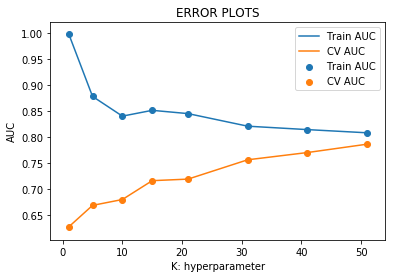

In [55]:
# this was run with 10K data points only 
findBestK(X_train_bow_dense, y_train, X_cv_bow_dense, y_cv, K, 'kd_tree')

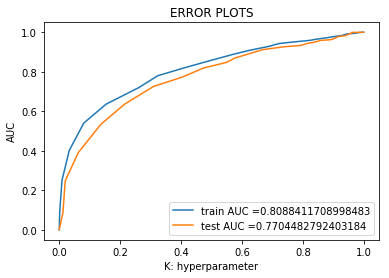

y_train class counts
1    3599
0     671
Name: Score, dtype: int64
y_test class counts
1    1401
0     255
Name: Score, dtype: int64
Train confusion matrix
[[  37  634]
 [  32 3567]]
Test confusion matrix
[[  14  241]
 [  19 1382]]


In [56]:
# best k seems to occur at 50 on the CV data 
bestk = 50  
computeWithBestK(bestk, X_train_bow_dense, y_train, X_test_bow_dense, y_test, 'kd_tree')   

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [101]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=10)
vectorizer.fit(X_train) 

# we use the fitted vectorizer to convert the text to vector
X_train_tfidf = vectorizer.transform(X_train)
X_cv_tfidf = vectorizer.transform(X_cv)
X_test_tfidf = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)

print(type(X_train_tfidf))
X_train_tfidf_dense = X_train_tfidf.toarray()
X_cv_tfidf_dense = X_cv_tfidf.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()

print(type(x_train_tfidf_dense))

After vectorizations
(21114, 12239) (21114,)
(6306, 12239) (6306,)
(8190, 12239) (8190,)
<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.ndarray'>


100%|██████████| 8/8 [11:31<00:00, 94.22s/it]


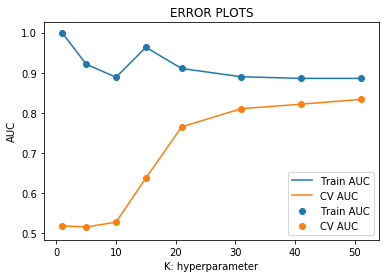

In [60]:
# this was run with 10K data points only 
findBestK(X_train_tfidf_dense, y_train, X_cv_tfidf_dense, y_cv, K, 'kd_tree')

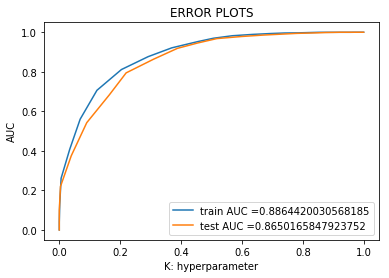

y_train class counts
1    3599
0     671
Name: Score, dtype: int64
y_test class counts
1    1401
0     255
Name: Score, dtype: int64
Train confusion matrix
[[  21  650]
 [   0 3599]]
Test confusion matrix
[[  10  245]
 [   0 1401]]


In [61]:
#for TFIDF the best score seems to be around K=50  
bestk = 50   
computeWithBestK(bestk, X_train_tfidf_dense, y_train, X_test_tfidf_dense, y_test, 'kd_tree')    


### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

100%|██████████| 21114/21114 [00:28<00:00, 738.36it/s]


(21114, 50)
[ 1.25908529e+00  4.10572452e-01 -8.09076403e-01  9.54783592e-02
  3.28209622e-02  5.18802607e-01  6.83745415e-01  5.32306341e-01
 -1.93320721e-01  6.21974414e-01 -3.45025818e-01 -6.22937619e-01
  5.71168449e-01  7.21171134e-01  4.86557345e-01 -3.87681841e-01
 -1.31058511e+00  4.26924680e-01  7.15454898e-01  2.79941679e-01
  4.91952234e-01  1.65232490e-01 -1.03346748e+00 -1.38395880e+00
  1.41190366e-01 -3.47602754e-01  4.66670138e-01 -1.59114514e-01
  4.03325406e-02  6.77252802e-02 -5.61399158e-01 -3.87223402e-01
 -8.61961528e-04 -5.66019220e-01  3.67728553e-01 -2.20084670e-01
 -6.50712494e-01 -1.10375483e+00 -1.38402218e-01 -9.25696494e-01
 -8.36431741e-01  3.43573263e-01 -1.53397782e-01 -2.59826729e-01
 -1.26759861e-01 -1.64110752e-01 -3.67073483e-01 -9.21212385e-01
  4.45883462e-01  2.07585444e-01]


  0%|          | 0/8 [00:00<?, ?it/s]

(6306, 50)
[ 0.26705551  0.35168104  0.25187186  0.0430147  -0.02583381  0.33161898
 -0.50528092 -0.02587186 -0.19294799  0.43141042 -0.18481261 -0.51981188
  0.62940413  0.33419473  0.06780154  0.52801859 -0.38311777  0.45969797
  0.59550995  0.34532699  0.08093421 -0.51470337 -0.28664636 -0.7965646
 -0.30221858 -0.21796107  0.23846154  0.45230556 -0.26127945  0.06468096
 -0.20360599  0.37730895 -0.34084673  0.28584874  0.00372759 -0.18513125
  0.22846525 -0.6047803   0.06799808 -0.35456591  0.30402802  0.07362201
 -0.00598939  0.03390868  0.31459739 -0.3197379  -0.5092181  -0.43591914
  0.11470002  0.37566399]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


100%|██████████| 8/8 [09:39<00:00, 77.69s/it]


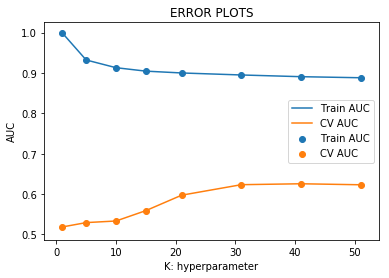

In [102]:
# It was run with 50k data points
X_train_w2vAvg = computeAvgW2V(X_train)
X_cv_w2vAvg = computeAvgW2V(X_cv)

print(type(X_train_w2vAvg))
print(type(X_cv_w2vAvg))

findBestK(X_train_w2vAvg, y_train, X_cv_w2vAvg, y_cv, K, 'kd_tree')

100%|██████████| 8190/8190 [00:09<00:00, 856.97it/s]


(8190, 50)
[ 0.44860686  0.27477915 -0.19504274  0.09698405 -0.17597843 -0.42791732
 -0.38134129 -0.07146016 -0.07493166  0.22351711 -0.76981997 -0.46618986
  0.30511611  0.16674421 -0.14384506  0.38216309 -0.40805017  0.24061763
  0.41436458  0.38952062  0.32029492 -0.52173317 -0.00874167 -0.32538948
 -0.01220131 -0.0694322   0.06055134  0.25427426  0.04759469  0.48229675
 -0.49692008  0.13124971 -0.16377191 -0.07779555 -0.28454058 -0.0057687
  0.2518219  -0.63968719 -0.07282865 -0.75786974  0.22974649  0.21738652
  0.24584965 -0.06774181 -0.0715845  -0.06536369  0.03057927 -0.38307962
  0.1422885   0.47200006]
<class 'numpy.ndarray'>


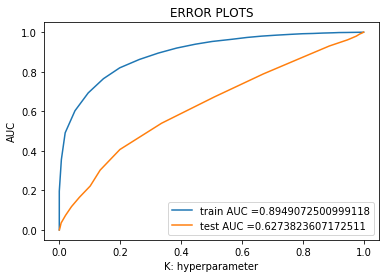

y_train class counts
1    17598
0     3516
Name: Score, dtype: int64
y_test class counts
1    6693
0    1497
Name: Score, dtype: int64
Train confusion matrix
[[ 1012  2504]
 [  261 17337]]
Test confusion matrix
[[  79 1418]
 [ 257 6436]]


In [103]:
#bestK is at 31 on CV data
bestk = 31
X_test_w2vAvg = computeAvgW2V(X_test)
print(type(X_test_w2vAvg))
computeWithBestK(bestk, X_train_w2vAvg, y_train, X_test_w2vAvg, y_test, 'kd_tree') 

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

  0%|          | 0/8 [00:00<?, ?it/s]

<class 'list'>
<class 'list'>


100%|██████████| 8/8 [08:33<00:00, 67.59s/it]


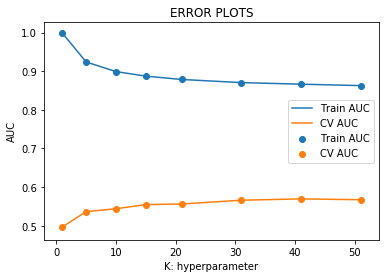

In [104]:
#It was run with 50k data points
X_train_w2vTfIdf = computeTfIdfW2v(X_train)
X_cv_w2vTfIdf = computeTfIdfW2v(X_cv)

print(type(X_train_w2vTfIdf))
print(type(X_cv_w2vTfIdf))

findBestK(X_train_w2vTfIdf, y_train, X_cv_w2vTfIdf, y_cv, K, 'kd_tree')

100%|██████████| 8190/8190 [00:25<00:00, 316.35it/s]


<class 'list'>


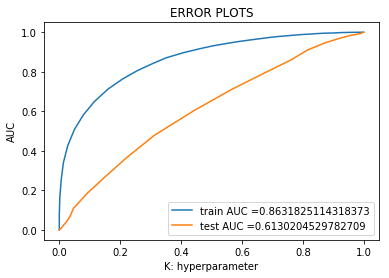

y_train class counts
1    17598
0     3516
Name: Score, dtype: int64
y_test class counts
1    6693
0    1497
Name: Score, dtype: int64
Train confusion matrix
[[  706  2810]
 [  201 17397]]
Test confusion matrix
[[   1 1496]
 [   0 6693]]


In [107]:
#bestK is at 50 based on CV data
bestk = 50
X_test_w2vTfIdf = computeTfIdfW2v(X_test)
print(type(X_test_w2vTfIdf))

computeWithBestK(bestk, X_train_w2vTfIdf, y_train, X_test_w2vTfIdf, y_test, 'kd_tree')  

In [3]:
import sys
!{sys.executable} -m pip install PTable

  Running setup.py bdist_wheel for PTable ... done
  Stored in directory: /Users/VJAYANTI/Library/Caches/pip/wheels/22/cc/2e/55980bfe86393df3e9896146a01f6802978d09d7ebcba5ea56
Successfully built PTable
You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# [6] Conclusions


HyperParameter :

1. Tried to find best K using the following K values : K = [1, 5, 10, 15, 21, 31, 41, 51]

Parameter(s) :

0. Tried to do a TimeSeries Train, CV, Test split by querying in Descending Time Order and swapping the train and test output's in call to train_test_split() method. This was based on what was mentioned in the lectures, that product reviews could change over time. And the data span was quiet large where oldest reviews were 20 years old. So i decided to discard old data.

1. The min_count/min_dif threshold parameter was set to 1 for BOW vectorizer but was set to 10 for TFIDF and 5 for W2V. This was to ignore terms that have a document frequency strictly lower than the given threshold, thereby reducing the number of features and computation time (to an extent).

2. Had to reduce the number of samples with KD Tree algorithm as the KD construction was time consuming. When tried with 150K samples, the BOW KD-Tree would not complete one iteration even after 45 minutes.


Results :

1. Results are in the table below


In [11]:

from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Vectorizer", "Algorithm", "HyperParameter", "AUC", "DataSize", "AvgSecsPerIteration", "min_count"]
x.add_row(["BOW", "Brute", 10, 0.66, "150k", 262.96, 1])
x.add_row(["TFIDF", "Brute", 10, 0.509, "150k", 296.50, 10])
x.add_row(["W2VAVG", "Brute", 50, 0.739, "150k", 128.20, 5])
x.add_row(["W2VTFIDF", "Brute", 50, 0.733, "150k", 133.55, 5])
x.add_row(["BOW", "kd_tree", 50, 0.66, "10k", 91.88, 1])
x.add_row(["TFIDF", "kd_tree", 50, 0.509, "10k", 94.22, 10])
x.add_row(["W2VAVG", "kd_tree", 31, 0.62, "50k", 77.69, 5])
x.add_row(["W2VTFIDF", "kd_tree", 50, 0.61, "50k", 67.59, 5])

print("Tabular Results:")
print()
print()
print(x)

Tabular Results:


+------------+-----------+----------------+-------+----------+---------------------+-----------+
| Vectorizer | Algorithm | HyperParameter |  AUC  | DataSize | AvgSecsPerIteration | min_count |
+------------+-----------+----------------+-------+----------+---------------------+-----------+
|    BOW     |   Brute   |       10       |  0.66 |   150k   |        262.96       |     1     |
|   TFIDF    |   Brute   |       10       | 0.509 |   150k   |        296.5        |     10    |
|   W2VAVG   |   Brute   |       50       | 0.739 |   150k   |        128.2        |     5     |
|  W2VTFIDF  |   Brute   |       50       | 0.733 |   150k   |        133.55       |     5     |
|    BOW     |  kd_tree  |       50       |  0.66 |   10k    |        91.88        |     1     |
|   TFIDF    |  kd_tree  |       50       | 0.509 |   10k    |        94.22        |     10    |
|   W2VAVG   |  kd_tree  |       31       |  0.62 |   50k    |        77.69        |     5     |
|  W2VTFIDF

Observations :

1. The AUC for W2V based Vectorizer seem to be better than corresponding BOW and TFIDF Vectorizer results for both Brute and kd_tree algorithms.

2. The Average Time taken per iteration also seems to be better for W2V. 

3. For Brute force TFIDF its not clear why the model perfomed like an AverageModel even when trained with 150k points. One Likely reason is the use of min_df=10 which resulted in a drop in number of -ve samples in y_test as seen in the confusion matrix for TFIDF-Brute (TN=22, FP=55) even though the original y_test had many more -ve samples.